# RNNs: How To Implement A Basic RNN

### Read In, Clean, And Split The Data

In [2]:
# Read in data and split into training and test set
# NOTE: we are NOT cleaning the data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

messages = pd.read_csv('../../../data/spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'],
                                                    labels, test_size=0.2)

### Prep Data For Modeling

In [4]:
# Install keras
# !pip install -U keras
!pip install -U tensorflow

     |████████████████████████████████| 320.4MB 528kB/s 
     |████████████████████████████████| 1.3MB 715kB/s 
     |████████████████████████████████| 133kB 916kB/s 
  Using cached https://files.pythonhosted.org/packages/bc/19/404708a7e54ad2798907210462fd950c3442ea51acc8790f3da48d2bee8b/opt_einsum-3.3.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8a/48/a76be51647d0eb9f10e2a4511bf3ffb8cc1e6b14e9e4fab46173aa79f981/termcolor-1.1.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/79/4c/7c3275a01e12ef9368a892926ab932b33bb13d55794881e3573482b378a7/Keras_Preprocessing-1.1.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a3/de/c648ef6835192e6e2cc03f40b19eeda4382c49b5bafb43d88b931c4c74ac/google_pasta-0.2.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org

In [5]:
# Import the tools we will need from keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [6]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [7]:
# Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [8]:
# What do these sequences look like?
X_train_seq[0]

[98,
 16,
 86,
 219,
 220,
 927,
 18,
 1118,
 1995,
 1996,
 1997,
 380,
 1651,
 1998,
 72,
 3,
 17,
 176,
 4,
 249,
 338,
 170,
 26,
 634,
 146]

In [9]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [10]:
# What do these padded sequences look like?
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,   98,   16,   86,  219,  220,  927,   18, 1118,
       1995, 1996, 1997,  380, 1651, 1998,   72,    3,   17,  176,    4,
        249,  338,  170,   26,  634,  146], dtype=int32)

### Build Model

In [11]:
# Import the tools needed from keras and define functions to calculate recall and precision
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [12]:
# Construct a simple RNN model
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: &quot;sequential&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          254816    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 264,225
Trainable params: 264,225
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [14]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 6s 43ms/step - loss: 0.2286 - accuracy: 0.9280 - precision_m: 0.5718 - recall_m: 0.4922 - val_loss: 0.0701 - val_accuracy: 0.9803 - val_precision_m: 0.9810 - val_recall_m: 0.8863
Epoch 2/10
140/140 [==============================] - 4s 27ms/step - loss: 0.0293 - accuracy: 0.9928 - precision_m: 0.9728 - recall_m: 0.9451 - val_loss: 0.0564 - val_accuracy: 0.9830 - val_precision_m: 0.9498 - val_recall_m: 0.9430
Epoch 3/10
140/140 [==============================] - 4s 27ms/step - loss: 0.0110 - accuracy: 0.9975 - precision_m: 0.9631 - recall_m: 0.9606 - val_loss: 0.0573 - val_accuracy: 0.9848 - val_precision_m: 0.9857 - val_recall_m: 0.9184
Epoch 4/10
140/140 [==============================] - 4s 28ms/step - loss: 0.0041 - accuracy: 0.9993 - precision_m: 0.9786 - recall_m: 0.9737 - val_loss: 0.0876 - val_accuracy: 0.9839 - val_precision_m: 1.0000 - val_recall_m: 0.9041
Epoch 5/10
140/140 [==============================] - 4s 27ms/step -

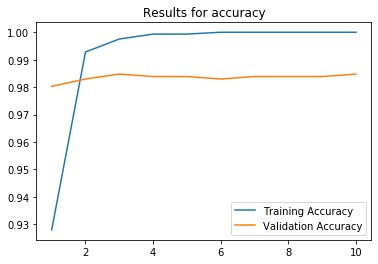

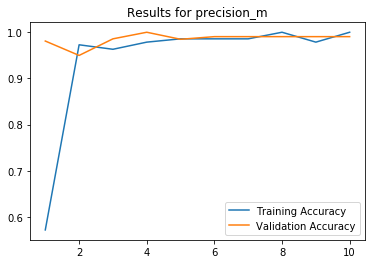

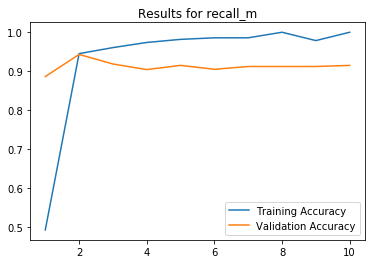

In [15]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()